# Importando bibliotecas

In [1]:
# Bibliotecas para tratar os dados
import pandas as pd
import numpy as np

# Bibliotecas para EDA
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt 

# Biblioteca para manipular diferentes partes do ambiente de tempo de execução do Python
import sys

# Biblioteca para manipular o sistema operacional
import os

# Adicionando o caminho na variavel ambiente de todas as coisas que são refatoradas
sys.path.append(os.getenv('PATH_SRC'))

# Bibliotecas para contrução do modelo
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error
import optuna


# Configurando para não exibir warnings
import warnings
warnings.filterwarnings("ignore")

# Importando funções criadas
import config, custom_funcs

c:\Users\dafne.piovesan\.conda\envs\projeto1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importando o dataset

In [2]:
#importando dataset de treino
data_train = pd.read_csv(config.house_prices_train)
data_train.shape

(1460, 81)

In [3]:
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#importando dataset de teste
data_test = pd.read_csv(config.house_prices_test)
data_test.shape

(1459, 80)

In [5]:
data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
#importando a target do dataset de teste
target_test = pd.read_csv(config.target)
target_test.shape

(1459, 2)

In [7]:
target_test.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


# Feature Engineering

In [13]:
data = data_train.copy()

In [14]:
print(f'O dataset possui {data.shape[0]} linhas')

O dataset possui 1460 linhas


In [15]:
num = data.select_dtypes(include=[np.number]).columns.tolist()
custom_funcs.RemoveOutliers(data,num[2:37],5)

print(f'Após a retirada, o dataset possui {data.shape[0]} linhas')

Após a retirada, o dataset possui 1367 linhas


In [16]:
#testando remover 1 das features que são altamente correlacionadas com outra feature

data = data.drop(columns = ['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd', 'TotalBsmtSF'])

In [17]:
X = data.drop(columns=['Id','SalePrice'])
y = data['SalePrice']

In [18]:
#removendo colunas que tenham mais de 95% dos dados em 1 categoria
for col_cat in X.select_dtypes(exclude=[np.number]).columns.tolist():
    for cats in X[col_cat].unique():
        qtde_cat = X[X[col_cat] == cats].shape[0]
        total = X.shape[0]

        if (qtde_cat/total) > 0.95:
            X.drop(columns=col_cat, inplace=True)
            break

In [19]:
print(f'Após as remoções, o dataset possui {X.shape[1]} colunas')

Após as remoções, o dataset possui 69 colunas


In [20]:
X.isnull().sum().sort_values(ascending=0).head(15)

PoolQC          1367
MiscFeature     1323
Alley           1282
Fence           1110
MasVnrType       816
FireplaceQu      662
LotFrontage      241
GarageType        71
GarageCond        71
GarageFinish      71
GarageQual        71
BsmtExposure      36
BsmtFinType2      35
BsmtFinType1      35
BsmtCond          35
dtype: int64

In [21]:
print('Valores únicos para PoolArea, quando PoolQC é nulo:')
print(X[X['PoolQC'].isnull()]['PoolArea'].unique())
#pode tratar com ND, significa que não tem piscina

print('\nValores únicos para Alley:')
print(X['Alley'].unique())
#pode tratar com ND (seria o equivalente a 'No alley access')

print('\nValores únicos para MiscFeature:')
print(X['MiscFeature'].unique())
#pode tratar com ND, (seria o equivalente a 'None')

print('\nValores únicos para MasVnrType:')
print(X['MasVnrType'].unique())
#pode tratar com ND, (seria o equivalente a 'None')

print('\nValores únicos para Fence:')
print(X['Fence'].unique())
#pode tratar com ND, (seria o equivalente a 'No Fence')

print('\nValores únicos para Fireplaces, quando FireplaceQu é nulo:')
print(X[X['FireplaceQu'].isnull()]['Fireplaces'].unique())
#pode tratar com ND, (seria o equivalente a 'No Fireplace')

print('\nValores únicos para GarageArea, quando GarageQual ou GarageCond ou GarageFinish ou GarageType são nulos:')
print(X[X['GarageQual'].isnull()]['GarageArea'].unique())
print(X[X['GarageCond'].isnull()]['GarageArea'].unique())
print(X[X['GarageFinish'].isnull()]['GarageArea'].unique())
print(X[X['GarageType'].isnull()]['GarageArea'].unique())
#pode tratar com ND, (seria o equivalente a 'No Garage')

Valores únicos para PoolArea, quando PoolQC é nulo:
[0]

Valores únicos para Alley:
[nan 'Grvl' 'Pave']

Valores únicos para MiscFeature:
[nan 'Shed' 'Othr']

Valores únicos para MasVnrType:
['BrkFace' nan 'Stone' 'BrkCmn']

Valores únicos para Fence:
[nan 'GdWo' 'GdPrv' 'MnPrv' 'MnWw']

Valores únicos para Fireplaces, quando FireplaceQu é nulo:
[0]

Valores únicos para GarageArea, quando GarageQual ou GarageCond ou GarageFinish ou GarageType são nulos:
[0]
[0]
[0]
[0]


In [22]:
y = np.log(y)

In [23]:
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X.select_dtypes(exclude=[np.number])

#selecionando features categóricas que possuem uma ordem hierarquica
columns = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'BsmtQual', 'BsmtCond', 'FireplaceQu', \
    'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'PoolQC', 'Fence']

categorical_columns1 = categorical_columns[columns].columns.tolist()
categorical_columns2 = categorical_columns.drop(columns = columns).columns.tolist()

In [24]:
ordem_categorias = {
    'ExterQual': ['Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['ND', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['ND', 'Po', 'Fa', 'TA', 'Gd'],
    'PoolQC': ['ND', 'Fa', 'Gd', 'Ex'],
    'FireplaceQu': ['ND', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageQual': ['ND', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['ND', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['ND', 'No', 'Mn', 'Av', 'Gd'], 
    'BsmtFinType1': ['ND', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['ND', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'Fence': ['ND', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
encoders = [
    OneHotEncoder(drop='first', handle_unknown = 'ignore'),
    TargetEncoder(random_state = 42)    
]

preprocessor_list = []

for encoder in encoders:

    # garageyear_transform = Pipeline(steps=[
    #     ("garage_bin", custom_funcs.NullToBinary('GarageYrBlt'))
    #     ]
    # )

    numerical_transform = Pipeline(steps=[
        ("imputer_num", SimpleImputer(strategy='median')),
        ]
    )

    categorical_transform1 = Pipeline(steps=[
            ("imputer_cat1", SimpleImputer(strategy='constant', fill_value='ND')),
            ("encoder1", custom_funcs.CustomOrdinalEncoder(categories_dict = ordem_categorias, columns = columns))
        ]
    )
    
    categorical_transform2 = Pipeline(steps=[
            ("imputer_cat2", SimpleImputer(strategy='constant', fill_value='ND')),
            ("encoder2", encoder)
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            # ("garageyear", garageyear_transform, ['GarageYrBlt']),
            ("num", numerical_transform, numerical_columns),
            ("cat1", categorical_transform1, categorical_columns1),
            ("cat2", categorical_transform2, categorical_columns2)
        ]
    )

    preprocessor_list.append(preprocessor)

In [27]:
models_dict = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost':XGBRegressor(random_state=42),
    'LGBM': LGBMRegressor(random_state=42, verbose = -100)
}   

results = []

for encoder, preprocessor in zip(encoders, preprocessor_list):
    for label, model in models_dict.items():

        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("selector", VarianceThreshold()),
            ("classifier", model)
        ])

        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        metrics = - cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring = 'neg_root_mean_squared_error')

        print(f'{label} / {encoder} : {metrics}')

        rmse = metrics.mean()

        results.append((encoder, label, rmse))


results_df = pd.DataFrame(results, columns=['encoder', 'model', 'rmse'])

results_df.sort_values('rmse', ascending=True)

LinearRegression / OneHotEncoder(drop='first', handle_unknown='ignore') : [0.1167301  0.120682   0.11311772 0.12539138 0.14957297]
RandomForest / OneHotEncoder(drop='first', handle_unknown='ignore') : [0.12974268 0.14512356 0.13917668 0.14559614 0.14478307]
XGBoost / OneHotEncoder(drop='first', handle_unknown='ignore') : [0.11944763 0.14705148 0.1433167  0.13461585 0.14666977]
LGBM / OneHotEncoder(drop='first', handle_unknown='ignore') : [0.11405547 0.13197377 0.12723444 0.12853826 0.13627023]
LinearRegression / TargetEncoder(random_state=42) : [0.11371156 0.11641995 0.11403806 0.11407646 0.11893165]
RandomForest / TargetEncoder(random_state=42) : [0.12592878 0.15066498 0.14456542 0.13878931 0.14174014]
XGBoost / TargetEncoder(random_state=42) : [0.12799951 0.15056956 0.13971966 0.13877784 0.14729169]
LGBM / TargetEncoder(random_state=42) : [0.12111158 0.13729215 0.12685913 0.12371923 0.13210882]


,encoder,model,rmse
4,TargetEncoder(random_state=42),LinearRegression,0.115436
0,"OneHotEncoder(drop='first', handle_unknown='ig...",LinearRegression,0.125099
3,"OneHotEncoder(drop='first', handle_unknown='ig...",LGBM,0.127614
7,TargetEncoder(random_state=42),LGBM,0.128218
2,"OneHotEncoder(drop='first', handle_unknown='ig...",XGBoost,0.138220
5,TargetEncoder(random_state=42),RandomForest,0.140338
6,TargetEncoder(random_state=42),XGBoost,0.140872
1,"OneHotEncoder(drop='first', handle_unknown='ig...",RandomForest,0.140884


# Model

In [45]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.01)
    num_leaves = trial.suggest_int('num_leaves', 10, 100)
    min_data_in_leaf = trial.suggest_int('bagging_freq', 10, 200)
    max_depth = trial.suggest_int('max_depth', 15, 100)
    threshold = trial.suggest_float('threshold', 0, 0.3)
    k = trial.suggest_int('k', 10, 65)

    model = Pipeline(steps=[
            ("preprocessor", preprocessor_list[0]),
            ("selector1", VarianceThreshold(threshold = threshold)),
            ("selector2", SelectKBest(f_regression, k=k)),
            ("classifier", LGBMRegressor(learning_rate = learning_rate,
                        num_leaves = num_leaves,
                        min_data_in_leaf = min_data_in_leaf,
                        max_depth = max_depth,
                        n_jobs = -1,
                        random_state = 42, 
                        verbose = -100))
        ]
    )
    
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
    metrics = - cross_val_score(model, X_test, y_test, cv = kfold, scoring = 'neg_root_mean_squared_error')

    rmse = metrics.mean()

    return rmse

In [46]:
study = optuna.create_study(direction='minimize')

[I 2024-02-02 16:47:12,667] A new study created in memory with name: no-name-1ee5b71b-d3dc-4681-a92e-7588e72355a4


In [47]:
study.optimize(objective, n_trials=100)

[I 2024-02-02 16:47:14,783] Trial 0 finished with value: 0.24349395462883966 and parameters: {'learning_rate': 0.008882175025774538, 'num_leaves': 34, 'bagging_freq': 30, 'max_depth': 57, 'threshold': 0.12651056834167532, 'k': 15}. Best is trial 0 with value: 0.24349395462883966.
[I 2024-02-02 16:47:15,200] Trial 1 finished with value: 0.3516489175892094 and parameters: {'learning_rate': 0.002937548190342137, 'num_leaves': 91, 'bagging_freq': 107, 'max_depth': 43, 'threshold': 0.2581888002839819, 'k': 49}. Best is trial 0 with value: 0.24349395462883966.
[I 2024-02-02 16:47:15,582] Trial 2 finished with value: 0.28578069968177167 and parameters: {'learning_rate': 0.009753257103269651, 'num_leaves': 70, 'bagging_freq': 100, 'max_depth': 66, 'threshold': 0.09527290990903087, 'k': 27}. Best is trial 0 with value: 0.24349395462883966.
[I 2024-02-02 16:47:15,948] Trial 3 finished with value: 0.3876467503701032 and parameters: {'learning_rate': 0.005845103799756296, 'num_leaves': 23, 'baggin

In [48]:
def objective2(trial):
    threshold = trial.suggest_float('threshold', 0, 0.3)
    k = trial.suggest_int('k', 10, 65)

    model = Pipeline(steps=[
            ("preprocessor", preprocessor_list[1]),
            ("selector1", VarianceThreshold(threshold = threshold)),
            ("selector2", SelectKBest(f_regression, k=k)),
            ("classifier", LGBMRegressor(n_jobs = -1,
                        random_state = 42, 
                        verbose = -100))
        ]
    )
    
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
    metrics = - cross_val_score(model, X_test, y_test, cv = kfold, scoring = 'neg_root_mean_squared_error')

    rmse = metrics.mean()

    return rmse

In [49]:
study2 = optuna.create_study(direction='minimize')

[I 2024-02-02 16:53:29,090] A new study created in memory with name: no-name-bd78bb6f-bdc5-4ae1-8207-d2177946b27f


In [50]:
study2.optimize(objective2, n_trials=100)

[I 2024-02-02 16:53:30,681] Trial 0 finished with value: 0.14540446093812034 and parameters: {'threshold': 0.24452825220014862, 'k': 64}. Best is trial 0 with value: 0.14540446093812034.
[I 2024-02-02 16:53:31,130] Trial 1 finished with value: 0.15024669708308555 and parameters: {'threshold': 0.0020123956946791143, 'k': 24}. Best is trial 0 with value: 0.14540446093812034.
[I 2024-02-02 16:53:31,601] Trial 2 finished with value: 0.14547921975727107 and parameters: {'threshold': 0.18811672069024885, 'k': 41}. Best is trial 0 with value: 0.14540446093812034.
[I 2024-02-02 16:53:32,080] Trial 3 finished with value: 0.14721405751292665 and parameters: {'threshold': 0.2695514941230372, 'k': 60}. Best is trial 0 with value: 0.14540446093812034.
[I 2024-02-02 16:53:32,527] Trial 4 finished with value: 0.14566081891470692 and parameters: {'threshold': 0.11535510917466901, 'k': 53}. Best is trial 0 with value: 0.14540446093812034.
[I 2024-02-02 16:53:32,990] Trial 5 finished with value: 0.14547

In [51]:
def objective3(trial):
    threshold = trial.suggest_float('threshold', 0, 0.3)
    k = trial.suggest_int('k', 10, 65)

    model = Pipeline(steps=[
            ("preprocessor", preprocessor_list[1]),
            ("selector1", VarianceThreshold(threshold = threshold)),
            ("selector2", SelectKBest(f_regression, k=k)),
            ("classifier", LinearRegression())
        ]
    )
    
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
    metrics = - cross_val_score(model, X_test, y_test, cv = kfold, scoring = 'neg_root_mean_squared_error')

    rmse = metrics.mean()

    return rmse

In [52]:
study3 = optuna.create_study(direction='minimize')

[I 2024-02-02 16:56:23,744] A new study created in memory with name: no-name-b9561435-5d95-40c3-b964-c87d4691dde3


In [53]:
study3.optimize(objective2, n_trials=100)

[I 2024-02-02 16:56:25,691] Trial 0 finished with value: 0.1464591768562703 and parameters: {'threshold': 0.032758352666586006, 'k': 33}. Best is trial 0 with value: 0.1464591768562703.
[I 2024-02-02 16:56:26,172] Trial 1 finished with value: 0.1491069376432007 and parameters: {'threshold': 0.14847893075260524, 'k': 31}. Best is trial 0 with value: 0.1464591768562703.
[I 2024-02-02 16:56:26,638] Trial 2 finished with value: 0.14964997449565734 and parameters: {'threshold': 0.15706061942770463, 'k': 21}. Best is trial 0 with value: 0.1464591768562703.
[I 2024-02-02 16:56:27,116] Trial 3 finished with value: 0.14160331618497327 and parameters: {'threshold': 0.04417457696446363, 'k': 57}. Best is trial 3 with value: 0.14160331618497327.
[I 2024-02-02 16:56:27,577] Trial 4 finished with value: 0.14717876748098896 and parameters: {'threshold': 0.07281869361198624, 'k': 30}. Best is trial 3 with value: 0.14160331618497327.
[I 2024-02-02 16:56:28,041] Trial 5 finished with value: 0.1467475067

In [54]:
study2.best_params

{'threshold': 0.007743838124454098, 'k': 61}

In [55]:
best_params = study2.best_params

best_threshold = best_params['threshold']
best_k = best_params['k']

In [56]:
model = Pipeline(steps=[
            ("preprocessor", preprocessor_list[1]),
            ("selector1", VarianceThreshold()),
            ("selector2", SelectKBest(f_regression, k=best_k)),
            ("classifier", LinearRegression())
            #  LGBMRegressor(
            #             random_state = 42,
            #             n_jobs = -1,
            #             verbose = -100))
        ]
    )
    
kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
metrics = - cross_val_score(model, X_test, y_test, cv = kfold, scoring = 'neg_root_mean_squared_error')

rmse = metrics.mean()
print(rmse)

0.13468811037968947


In [57]:
best_model = LinearRegression()
#LGBMRegressor(random_state = 42, n_jobs = -1,verbose = -100)

In [58]:
best_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("selector1", VarianceThreshold(threshold=best_threshold)),
        ("selector2", SelectKBest(f_regression, k=best_k)),
        ("classifier", best_model)
])

best_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'Bsm...
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'Foundation',
                                                   'CentralAir', 'Electrical',
                                                   'Functional', 'GarageType',
                                                   'GarageFinish', 'PavedDrive',
                                                   'MiscFeature', 'SaleType',
                                                   'SaleCondition'])])),
                ('selector1',
                 VarianceThreshold(threshold=0.007743838124454098)),
                ('selector2',
                 SelectKBest(k=61,
                             score_func=<function f_regression at 0x000002CED2F85D00>)),
                ('classifier', LinearRegression())])

In [60]:
test_final = data_test.copy()

In [61]:
data_test_ID = data_test['Id']

test_final.drop(columns='Id', inplace=True)

In [62]:
y_pred = best_pipeline.predict(test_final)

In [63]:
y_pred_escalareal = np.exp(y_pred)

In [64]:
target_test['Predict_SalePrice'] = y_pred_escalareal

In [65]:
target_test

,Id,SalePrice,Predict_SalePrice
0,1461,169277.052498,112795.185843
1,1462,187758.393989,170497.405912
2,1463,183583.683570,176677.007002
3,1464,179317.477511,200496.523276
4,1465,150730.079977,191305.454665
...,...,...,...
1454,2915,167081.220949,89315.985613
1455,2916,164788.778231,85981.101687
1456,2917,219222.423400,180466.190147
1457,2918,184924.279659,118766.640770


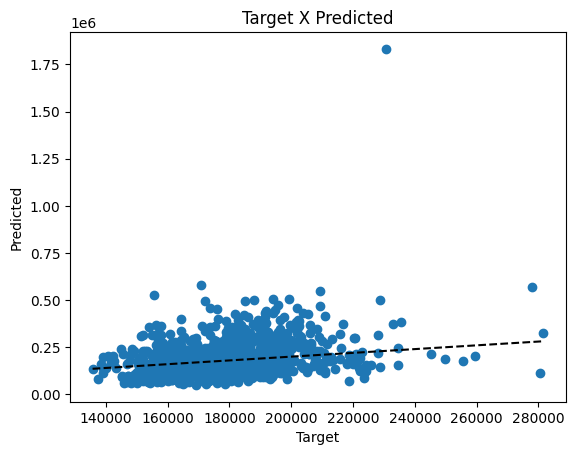

In [66]:
plt.scatter(target_test['SalePrice'], target_test['Predict_SalePrice'])
plt.plot([min(target_test['SalePrice']), max(target_test['SalePrice'])], [min(target_test['SalePrice']), max(target_test['SalePrice'])], '--', color='black')

plt.xlabel('Target')
plt.ylabel('Predicted')

plt.title('Target X Predicted')

plt.show()

In [67]:
residual = (target_test['SalePrice'] - target_test['Predict_SalePrice'])
residual

0       56481.866656
1       17260.988077
2        6906.676568
3      -21179.045765
4      -40575.374688
            ...     
1454    77765.235336
1455    78807.676544
1456    38756.233253
1457    66157.638889
1458   -32928.207292
Length: 1459, dtype: float64

In [68]:
res = stats.shapiro(residual)
res.statistic

0.7388368844985962

In [69]:
res.pvalue

5.324934164434305e-43

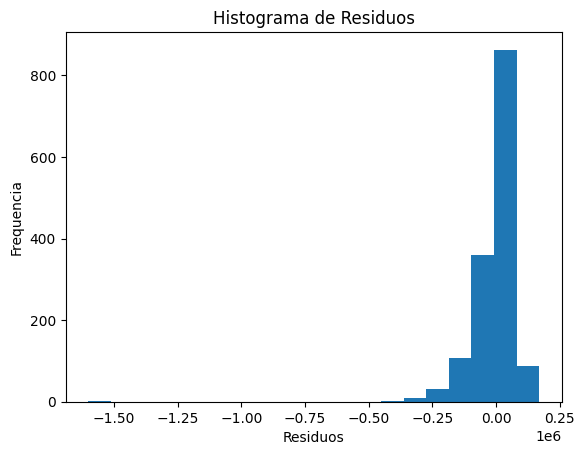

In [70]:
plt.hist(residual, bins=20)
plt.xlabel("Residuos")
plt.ylabel("Frequencia")
plt.title("Histograma de Residuos")
plt.show()

In [71]:
rmse_pred = root_mean_squared_error(target_test['SalePrice'], target_test['Predict_SalePrice'])
rmse_pred

85171.32019460427

In [72]:
rmse_pred = root_mean_squared_error(np.log(target_test['SalePrice']), np.log(target_test['Predict_SalePrice']))
rmse_pred

0.39058486295580674